<a href="https://colab.research.google.com/github/ManvithMali/ProjectNotebooks/blob/main/age_gender_gpu_r2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/MyDrive/UTKFace/UTKFace/

%ls

/content/drive/MyDrive/UTKFace/UTKFace
model_checkpoint/  model.png  UTKFace/


In [ ]:
dataset_folder_name = 'UTKFace'

TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198

dataset_dict = {
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())

In [ ]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df.columns = ['age', 'gender', 'file']
    df['file'] = files    
    df = df.dropna()    
    return df

In [ ]:
df = parse_dataset(dataset_folder_name)
df.head()

,age,gender,file
0,22.0,female,UTKFace/22_1_2_20170104231245440.jpg.chip.jpg
1,27.0,female,UTKFace/27_1_2_20170116172207087.jpg.chip.jpg
2,34.0,male,UTKFace/34_0_3_20170119165802654.jpg.chip.jpg
3,20.0,female,UTKFace/20_1_1_20170116214348718.jpg.chip.jpg
4,29.0,male,UTKFace/29_0_0_20170117122025363.jpg.chip.jpg


In [ ]:
import plotly.graph_objects as go
from IPython.display import display, Image

def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
        
    img_bytes = fig.to_image(format="png")
    display(Image(img_bytes))

In [ ]:
import plotly.express as px
fig = px.histogram(df, x="age", nbins=20)
fig.update_layout(title_text='Age distribution')
fig.show()

In [ ]:
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']

age_binned = pd.cut(df['age'], bins, labels=names)



In [ ]:

from keras.utils import to_categorical
from PIL import Image

class UtkFaceDataGenerator():
    """
    Data generator for the UTKFace dataset. This class should be used when training our Keras multi-output model.
    """
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]

        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        
        # converts alias to id
        self.df['gender_id'] = self.df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
        #self.df['race_id'] = self.df['race'].map(lambda race: dataset_dict['race_alias'][race])

        self.max_age = self.df['age'].max()
        
        return train_idx, valid_idx, test_idx
    
    def preprocess_image(self, img_path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        im = Image.open(img_path)
        im = im.resize((IM_WIDTH, IM_HEIGHT))
        im = np.array(im) / 255.0
        
        return im
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        
        # arrays to store our batched data
        images, ages, genders = [], [], []
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]
                
                age = person['age']
                gender = person['gender_id']
                file = person['file']
                
                im = self.preprocess_image(file)
                
                ages.append(age / self.max_age)
                genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
                images.append(im)
                
                # yielding condition
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(ages), np.array(genders)]
                    images, ages, genders = [], [],  []
                    
            if not is_training:
                break
                
data_generator = UtkFaceDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()

In [ ]:
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
import tensorflow as tf

class UtkMultiOutputModel():
    """
    Used to generate our multi-output model. This CNN contains three branches, one for age, other for 
    sex and another for race. Each branch contains a sequence of Convolutional Layers that is defined
    on the make_default_hidden_layers method.
    """
    def make_default_hidden_layers(self, inputs):
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:
        
        Conv2D -> BatchNormalization -> Pooling -> Dropout
        """
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        return x

    def build_race_branch(self, inputs, num_races):
        """
        Used to build the race branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_races)(x)
        x = Activation("softmax", name="race_output")(x)

        return x

    def build_gender_branch(self, inputs, num_genders=2):
        """
        Used to build the gender branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_genders)(x)
        x = Activation("sigmoid", name="gender_output")(x)

        return x

    def build_age_branch(self, inputs):   
        """
        Used to build the age branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.

        """
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)

        return x

    def assemble_full_model(self, width, height):
        """
        Used to assemble our multi-output model CNN.
        """
        input_shape = (height, width, 3)

        inputs = Input(shape=input_shape)

        age_branch = self.build_age_branch(inputs)

        gender_branch = self.build_gender_branch(inputs)

        model = Model(inputs=inputs,
                     outputs = [age_branch, gender_branch],
                     name="face_net")

        return model
    
model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT)


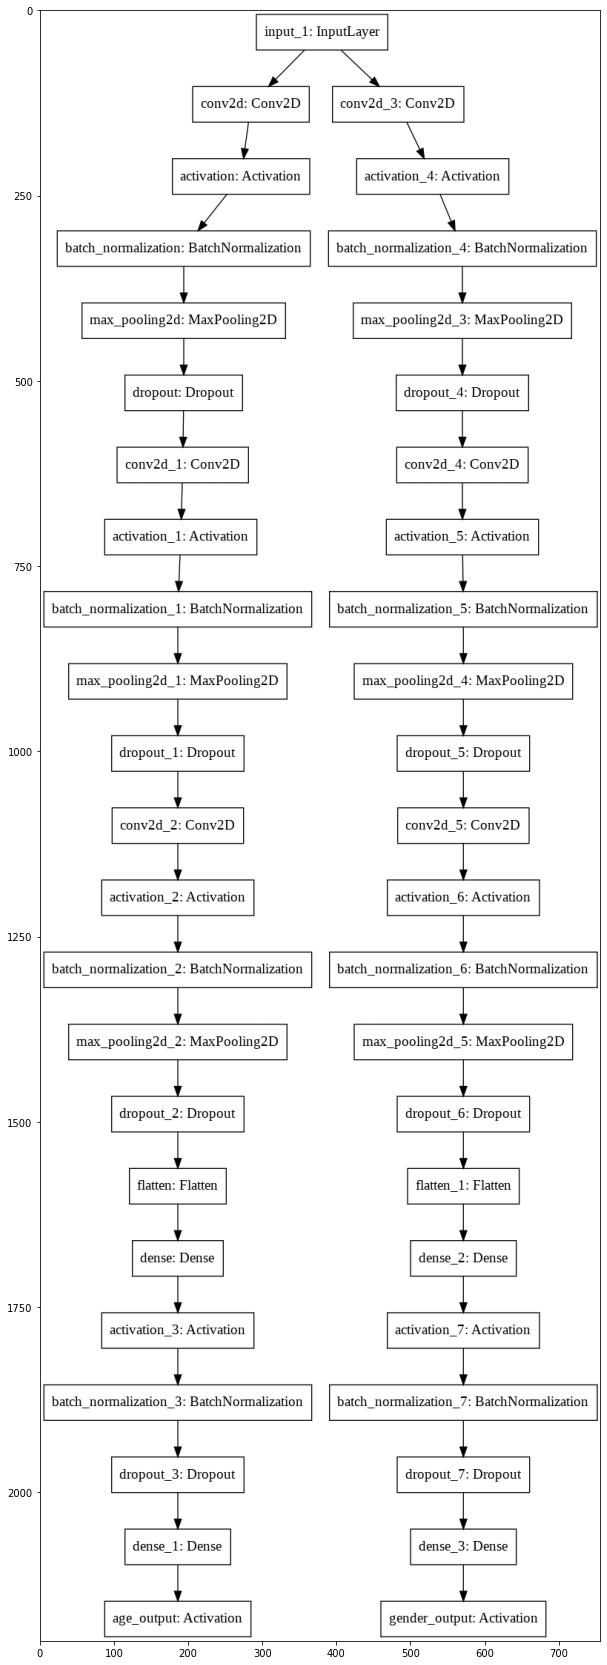

In [ ]:

%matplotlib inline

from keras.utils import plot_model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plot_model(model, to_file='model.png')
img = mpimg.imread('model.png')

plt.figure(figsize=(40, 30))
plt.imshow(img)

In [ ]:
model.summary()

Model: "face_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 198, 198, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 198, 198, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 198, 198, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 198, 198, 16) 0           conv2d[0][0]                     
___________________________________________________________________________________________

In [ ]:
from keras.optimizers import Adam

init_lr = 1e-4
epochs = 15

opt = Adam(lr=init_lr, decay=init_lr / epochs)

model.compile(optimizer=opt, 
              loss={
                  'age_output': 'mse', 
                  'gender_output': 'binary_crossentropy'},
              loss_weights={
                  'age_output': 4., 
                  'gender_output': 0.1},
              metrics={
                  'age_output': 'mae', 
                  'gender_output': 'accuracy'})

In [ ]:
from keras.callbacks import ModelCheckpoint

batch_size = 32
valid_batch_size = 32
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/15
362/362 [==============================] - 4011s 11s/step - loss: 13.9410 - age_output_loss: 3.4670 - gender_output_loss: 0.7289 - age_output_mae: 1.4535 - gender_output_accuracy: 0.6935 - val_loss: 36.2944 - val_age_output_loss: 9.0538 - val_gender_output_loss: 0.7903 - val_age_output_mae: 2.7369 - val_gender_output_accuracy: 0.5752
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
Epoch 2/15
362/362 [==============================] - 846s 2s/step - loss: 7.8652 - age_output_loss: 1.9537 - gender_output_loss: 0.5028 - age_output_mae: 1.0834 - gender_output_accuracy: 0.7978 - val_loss: 18.0094 - val_age_output_loss: 4.4918 - val_gender_output_loss: 0.4241 - val_age_output_mae: 1.3616 - val_gender_output_accuracy: 0.8290
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
Epoch 3/15
362/362 [==============================] - 848s 2s/step - loss: 5.7145 - age_output_loss: 1.4176 - gender_output_loss: 0.4393 - age_output_mae: 0.9123 - gender_output_accuracy:

In [ ]:
test_batch_size = 128
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
age_pred, gender_pred = model.predict_generator(test_generator, 
                                                           steps=len(test_idx)//test_batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



In [ ]:
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
samples = 0
images, age_true, race_true, gender_true = [], [], [], []
for test_batch in test_generator:
    image = test_batch[0]
    labels = test_batch[1]
    
    images.extend(image)
    age_true.extend(labels[0])
    race_true.extend(labels[1])
    gender_true.extend(labels[2])
    
age_true = np.array(age_true)
race_true = np.array(race_true)
gender_true = np.array(gender_true)

race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)

age_true = age_true * data_generator.max_age
age_pred = age_pred * data_generator.max_age

In [ ]:
from sklearn.metrics import classification_report

cr_race = classification_report(race_true, race_pred, target_names=dataset_dict['race_alias'].keys())
print(cr_race)

              precision    recall  f1-score   support

       white       0.00      0.00      0.00       0.0
       black       0.00      0.00      0.00       0.0
       asian       0.00      0.00      0.00     384.0
      indian       0.00      0.00      0.00       0.0
      others       0.00      0.00      0.00       0.0

    accuracy                           0.00     384.0
   macro avg       0.00      0.00      0.00     384.0
weighted avg       0.00      0.00      0.00     384.0



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [ ]:
cr_gender = classification_report(gender_true, gender_pred, target_names=dataset_dict['gender_alias'].keys())
print(cr_gender)

              precision    recall  f1-score   support

        male       0.59      0.70      0.64       200
      female       0.59      0.46      0.52       184

    accuracy                           0.59       384
   macro avg       0.59      0.58      0.58       384
weighted avg       0.59      0.59      0.58       384



In [ ]:
from sklearn.metrics import r2_score

print('R2 score for age: ', r2_score(age_true, age_pred))

R2 score for age:  -8.128103421337057


In [ ]:
model.save('h5model.h5') 

In [ ]:
h5model = tf.keras.models.load_model('h5model.h5')

# Show the model architecture
h5model.summary()

Model: "face_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 198, 198, 3) 0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 198, 198, 16) 448         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 198, 198, 16) 448         input_6[0][0]                    
__________________________________________________________________________________________________
activation_60 (Activation)      (None, 198, 198, 16) 0           conv2d_45[0][0]                  
___________________________________________________________________________________________

In [ ]:
tf.saved_model.save(model, './chekka/')

INFO:tensorflow:Assets written to: ./chekka/assets


In [ ]:
import pickle

Pkl_Filename = "myModel.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

AttributeError: ignored

In [ ]:
with open(Pkl_Filename, 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

Pickled_LR_Model

EOFError: ignored

In [ ]:
%pwd

'/content/drive/My Drive'

In [ ]:
export_dir='./chekka/'

newModel = tf.keras.models.load_model(export_dir)


#print(useModel.)

In [ ]:
test_batch_size = 128
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
age_pred, gender_pred = newModel.predict_generator(test_generator, 
                                                           steps=len(test_idx)//test_batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



In [ ]:
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
samples = 0
images, age_true, gender_true = [], [],  []
for test_batch in test_generator:
    image = test_batch[0]
    labels = test_batch[1]
    
    images.extend(image)
    age_true.extend(labels[0])

    gender_true.extend(labels[1])
    
age_true = np.array(age_true)
gender_true = np.array(gender_true)

gender_true = gender_true.argmax(axis=-1)
gender_pred = gender_pred.argmax(axis=-1)

age_true = age_true * data_generator.max_age
age_pred = age_pred * data_generator.max_age

In [ ]:
cr_gender = classification_report(gender_true, gender_pred, target_names=dataset_dict['gender_alias'].keys())
print(cr_gender)

              precision    recall  f1-score   support

        male       0.55      0.38      0.45       204
      female       0.48      0.66      0.56       180

    accuracy                           0.51       384
   macro avg       0.52      0.52      0.50       384
weighted avg       0.52      0.51      0.50       384



In [ ]:



fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 17))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(images[img_idx])
    
    cur_age_pred = age_pred[img_idx]
    cur_age_true = age_true[img_idx]
    
    cur_gender_pred = gender_pred[img_idx]
    cur_gender_true = gender_true[img_idx]
    
    cur_race_pred = race_pred[img_idx]
    cur_race_true = race_true[img_idx]
    
    age_threshold = 10
    if cur_gender_pred == cur_gender_true and cur_race_pred == cur_race_true and abs(cur_age_pred - cur_age_true) <= age_threshold:
        ax.xaxis.label.set_color('green')
    elif cur_gender_pred != cur_gender_true and cur_race_pred != cur_race_true and abs(cur_age_pred - cur_age_true) > age_threshold:
        ax.xaxis.label.set_color('red')
    
    ax.set_xlabel('a: {}, g: {}, r: {}'.format(int(age_pred[img_idx]),
                            dataset_dict['gender_id'][gender_pred[img_idx]],
                               dataset_dict['race_id'][race_pred[img_idx]]))
    
    ax.set_title('a: {}, g: {}, r: {}'.format(int(age_true[img_idx]),
                            dataset_dict['gender_id'][gender_true[img_idx]],
                               dataset_dict['race_id'][race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.savefig('preds.png')

In [ ]:
import numpy as np
from keras.preprocessing import image

img_width, img_height = 150, 150
img = image.load_img('./anasu.jpg', target_size = (img_width, img_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

newModel.predict(img)

ValueError: ignored

In [ ]:
import numpy as np
from keras.preprocessing import image
test_image1 = image.load_img('./anasu.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image1)
test_image = np.expand_dims(test_image, axis = 0)
result = newModel.predict(test_image)

print(result)


InvalidArgumentError: ignored

In [ ]:
im = Image.open('./anasu.jpg')
im = im.resize((IM_WIDTH, IM_HEIGHT))

im = np.array(im) / 255.0

im = im.reshape(1,IM_WIDTH, IM_HEIGHT,3)
print(im.shape)

(1, 198, 198, 3)


In [ ]:
test_batch_size = 128
#test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
age_pred, gender_pred = newModel.predict(im)


print(gender_pred)


[[0.4383252  0.49681407]]
